This notebook compares the gnubg bearoff database to our calculations. It assumes that you have generated the data files with these commands

`./compute.py 15 6`

`./gnubg_to_store.py ~/gnubg/gnubg-1.06.002/`

For the latter, it should be a directory where you have the source of gnubg downloaded and made


In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import board
import gnubg_interface
import strategy

# Load the data

In [3]:
!ls -l data/

total 50260
-rw-rw-r-- 1 pfr pfr 27284736 Mar 23 22:29 bgend_store_15_6.hdf5
-rw-rw-r-- 1 pfr pfr    37712 Mar 24 19:17 bgend_store_6_3.hdf5
-rw-rw-r-- 1 pfr pfr 24134504 Mar 22 21:47 gnubg_store_15_6.hdf5


In [4]:
%%time
our_store = strategy.DistributionStore.load_hdf5('data/bgend_store_15_6.hdf5')
gnubg_store = strategy.DistributionStore.load_hdf5('data/gnubg_store_15_6.hdf5')

CPU times: user 22.6 s, sys: 489 ms, total: 23.1 s
Wall time: 31.6 s


In [5]:
print(len(our_store.distribution_map))
print(len(gnubg_store.distribution_map))
assert(len(our_store.distribution_map) == len(gnubg_store.distribution_map))

54264
54264


# Examine the expected values

In [20]:
board_ids = []
our_expected_vals = []
their_expected_vals = []
for board_id in our_store.distribution_map:
    ours = our_store.distribution_map[board_id]
    theirs = gnubg_store.distribution_map[board_id]
    
    board_ids.append(board_id)
    our_expected_vals.append(ours.expected_value())
    their_expected_vals.append(theirs.expected_value())

our_expected_vals = np.array(our_expected_vals)
their_expected_vals = np.array(their_expected_vals)
diff_expected_vals = our_expected_vals - their_expected_vals

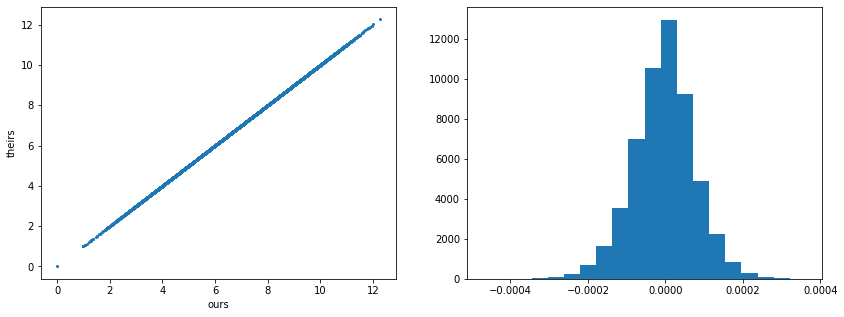

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].scatter(our_expected_vals, their_expected_vals, s=4)
axes[0].set_xlabel('ours')
axes[0].set_ylabel('theirs')

axes[1].hist(diff_expected_vals, bins=20)

pass

In [25]:
quantiles = [0, 0.001, 0.01, .99, .999, 1]
pd.DataFrame.from_dict({'quantile': quantiles, 
                        'value': np.quantile(diff_expected_vals, quantiles)})

,quantile,value
0,0.000,-0.000470
1,0.001,-0.000293
2,0.010,-0.000205
3,0.990,0.000187
4,0.999,0.000264
5,1.000,0.000363


# Examine the probabilities

In [ ]:
# The 1e-4 threshold is because of the limited precision from going through the text parsing from gnubg
total_boards = 0
total_correct = 0
for board_id in our_store.distribution_map:
    total_boards += 1
    ours_orig = our_store.distribution_map[board_id]
    ours = ours_orig.trim_low_prob(1e-5)
    theirs = gnubg_store.distribution_map[board_id]
    if len(ours) != len(theirs):
        print('Board ID {}, Position ID {}, different lengths\nours(orig): {}\nours(trim): {}\ntheirs  : {}'
              .format(board_id, gnubg_interface.board_id_to_gnubg_id_str(our_store.config, board_id), ours_orig, ours, theirs))
        continue

    if not np.allclose(ours.dist, theirs.dist, atol=1e-4):
        print('Board ID {}, Position ID {}, mismatch\nours(orig): {}\nours(trim): {}\ntheirs  : {}'
              .format(board_id, gnubg_interface.board_id_to_gnubg_id_str(our_store.config, board_id), ours_orig, ours, theirs))
        continue
        
    total_correct += 1
    
print('{}/{} correct ({:.2f}%)'.format(total_correct, total_boards, total_correct / total_boards))